# Assignment 3
## Reinforcement Learning Programming - CSCN 8020
### march 20, 2025

**Student Name:** Sreehari Prathap  
**Student ID:** 8903199  
**Student Email:** Sprathap3199@conestogac.on.ca

## Introduction

Deep reinforcement learning has revolutionized the field of artificial intelligence, enabling agents to learn complex decision-making tasks. In this project, we implement Deep Q-Learning (DQN) to train an AI agent to play the Atari game Pong using OpenAI Gym. The primary goal is to develop a neural network that approximates the Q-function, allowing the agent to maximize its long-term rewards by making optimal action decisions.

To achieve this, we preprocess game frames, design a convolutional neural network (CNN) for function approximation, and utilize experience replay to stabilize training. The agent follows an epsilon-greedy policy to balance exploration and exploitation, with hyperparameter tuning for improved performance. We experiment with different mini-batch sizes and target network update frequencies to analyze their impact on learning efficiency.

By the end of this project, we will evaluate our agent's performance based on episode scores and cumulative rewards, comparing different hyperparameter settings. Our findings will provide insights into how DQN-based agents can efficiently learn and adapt in dynamic environments.

## Experiments
- DQN Training on Pong – Train an agent using Deep Q-Networks (DQN) on Pong (PongDeterministic-v4).
- Hyperparameter Tweaks – Change mini-batch size and target network update rate to analyze performance.

## Key Parameters
- Batch size: 8 (default), tested with 16.
- Target network update rate: Every 10 episodes (default), tested with 3 episodes.
- Discount Factor (γ): 0.95.
- Exploration (ϵ): Starts at 1.0, decays by 0.995 per step, minimum 0.05.

## Evaluation Criteria
- Score per episode – Measures agent performance.
- Avg. Cumulative Reward (last 5 episodes) – Tracks learning progress.
- Impact of Parameter Changes – Compare results for different batch sizes and update rates.

## Environment Setup

### create a virtual environment
```bash
conda create -n dqn_pong python=3.9
conda activate dqn_pong
```

### install required packages
```bash
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
pip install gym gym[atari] numpy==1.23.5 matplotlib
pip install gym[accept-rom-license]
```

In [13]:
# %pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# %pip install gym gym[atari] numpy==1.23.5 matplotlib
# %pip install gym[accept-rom-license]

In [14]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

print("Gym version:", gym.__version__)
print("NumPy version:", np.__version__)
print("PyTorch version:", torch.__version__)

Gym version: 0.26.2
NumPy version: 1.26.3
PyTorch version: 2.6.0+cu126


## Step 1. Preprocessing and State Representation

In [15]:
import gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Step 2. Preprocessing and State Representation

- **`img_crop(img)`** – Crops unnecessary parts of the Pong game frame.  
- **`downsample(img)`** – Reduces image resolution by half.  
- **`transform_reward(reward)`** – Converts rewards to -1, 0, or 1 for stability.  
- **`to_grayscale(img)`** – Converts RGB image to grayscale.  
- **`normalize_grayscale(img)`** – Normalizes pixel values between -1 and 1.  
- **`process_frame(img, image_shape)`** – Applies all preprocessing steps and reshapes the image for model input.

In [16]:

# -------------------------------
# Preprocessing Functions
# -------------------------------
def img_crop(img):
    """Crop the image to focus on the game area."""
    return img[30:-12, :, :]

def downsample(img):
    """Downsample the image by taking every second pixel."""
    return img[::2, ::2]

def to_grayscale(img):
    """Convert the image to grayscale by averaging the RGB values."""
    return np.mean(img, axis=2).astype(np.uint8)

def normalize_grayscale(img):
    """Normalize the grayscale image to the range [-1, 1]."""
    return (img - 128) / 128 - 1

def process_frame(img, image_shape):
    """Process a single frame: crop, downsample, grayscale, and normalize."""
    img = img_crop(img)
    img = downsample(img)
    img = to_grayscale(img)
    img = normalize_grayscale(img)
    return np.expand_dims(img.reshape(image_shape[0], image_shape[1], 1), axis=0)

def preprocess_state(state, image_dims):
    """
    Preprocess a raw environment frame for the neural network.
    Args:
        state: Raw frame from gym (RGB image).
        image_dims: (height, width) tuple of the processed frame.
    Returns:
        Processed frame with shape (1, 1, height, width).
    """
    processed = process_frame(state, image_dims)
    processed = np.transpose(processed, (0, 3, 1, 2))  # Change shape to (1, 1, H, W)
    return processed



## Step 4. Replay Buffer Implementation

The replay buffer stores experience tuples (state, action, reward, next_state, done) and allows random sampling, which helps break the correlation between consecutive samples.

In [17]:
# -------------------------------
# Replay Buffer
# -------------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

## Step 5. Q-Network Architecture

This neural network approximates the Q-function. It takes a state (stacked frames) as input and outputs Q-values for each possible action.

In [18]:
# -------------------------------
# Q-Network (CNN)
# -------------------------------
class QNetwork(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(QNetwork, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            conv_out = self.features(dummy_input)
            conv_out_size = int(np.prod(conv_out.size()))

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


## Step 6. DQN Agent Implementation

The DQN agent combines all components. It:
- Maintains policy and target networks
- Selects actions using epsilon-greedy strategy
- Stores experiences in replay buffer
- Updates networks through gradient descent

In [19]:
class DQNAgent:
    def __init__(self, input_shape, num_actions, device,
                 batch_size=8, gamma=0.95, lr=1e-4,
                 epsilon_start=1.0, epsilon_decay=0.995, epsilon_min=0.05):
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.device = device
        self.batch_size = batch_size
        self.gamma = gamma

        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.policy_net = QNetwork(input_shape, num_actions).to(device)
        self.target_net = QNetwork(input_shape, num_actions).to(device)
        self.update_target_network()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(capacity=10000)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.num_actions)
        else:
            state_tensor = torch.FloatTensor(state).to(self.device)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()

    def push_memory(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)

        states = torch.FloatTensor(np.concatenate(states, axis=0)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.concatenate(next_states, axis=0)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.policy_net(states)
        state_action_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        next_q_values = self.target_net(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(state_action_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


## Step 7. Training Loop

This function handles the training process across multiple episodes.

In [20]:
# -------------------------------
# Training Loop
# -------------------------------
def train(agent, env, num_episodes, update_target_every, image_dims):
    scores = []
    avg_rewards = []
    
    print(f"\nStarting training with batch size: {agent.batch_size}, target update frequency: {update_target_every}")
    print(f"Discount factor: {agent.gamma}, Epsilon: {agent.epsilon} (decay: {agent.epsilon_decay}, min: {agent.epsilon_min})")

    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        processed = preprocess_state(state, image_dims)
        state_stack = np.concatenate([processed] * 4, axis=1)

        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state_stack)
            step_result = env.step(action)

            if len(step_result) == 5:
                next_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, info = step_result

            if isinstance(next_state, tuple):
                next_state = next_state[0]

            reward = np.sign(reward)
            processed_next = preprocess_state(next_state, image_dims)
            new_state_stack = np.concatenate([state_stack[:, 1:, :, :], processed_next], axis=1)

            agent.push_memory(state_stack, action, reward, new_state_stack, done)
            state_stack = new_state_stack
            total_reward += reward

            agent.update()

        scores.append(total_reward)
        avg_reward = np.mean(scores[-5:]) if len(scores) >= 5 else np.mean(scores)
        avg_rewards.append(avg_reward)

        # Decay epsilon after each episode
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

        print(f"Episode: {episode+1}, Score: {total_reward}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

        if (episode + 1) % update_target_every == 0:
            agent.update_target_network()
            print(f"Target network updated after episode {episode+1}")

        # Provide periodic analysis
        if (episode + 1) % 10 == 0 or episode == num_episodes - 1:
            print(f"\nTraining Summary (Episode {episode+1}):")
            print(f"Recent Average Score (last 5 episodes): {avg_reward:.2f}")
            print(f"Exploration rate (epsilon): {agent.epsilon:.3f}")
            print(f"Replay buffer size: {len(agent.memory)}")
            if episode >= 5:
                trend = "improving" if avg_rewards[-1] > avg_rewards[-6] else "declining"
                print(f"Performance trend: {trend}")
            print()

    # Final training summary
    print("\n" + "="*50)
    print(f"Training Complete - Hyperparameters Analysis")
    print(f"Batch size: {agent.batch_size} - {'Larger batches provide more stable gradients but slower updates' if agent.batch_size > 8 else 'Smaller batches allow faster learning but with more variance'}")
    print(f"Target update frequency: {update_target_every} - {'More frequent updates track policy changes closely but may be less stable' if update_target_every < 10 else 'Less frequent updates provide stability but slower adaptation'}")
    print(f"Final average reward (last 5 episodes): {avg_rewards[-1]:.2f}")
    print(f"Best average reward achieved: {max(avg_rewards):.2f}")
    print("="*50)

    return scores, avg_rewards


## Step 8. Setup and Execution

Create the Pong environment and configure it for training.

Using device: cuda
Number of actions: 6

Running experiment: Batch 8, Update 10

Starting training with batch size: 8, target update frequency: 10
Discount factor: 0.95, Epsilon: 1.0 (decay: 0.995, min: 0.05)
Episode: 1, Score: -21.0, Avg Reward: -21.00, Epsilon: 0.99
Episode: 2, Score: -21.0, Avg Reward: -21.00, Epsilon: 0.99
Episode: 3, Score: -19.0, Avg Reward: -20.33, Epsilon: 0.99
Episode: 4, Score: -21.0, Avg Reward: -20.50, Epsilon: 0.98
Episode: 5, Score: -19.0, Avg Reward: -20.20, Epsilon: 0.98
Episode: 6, Score: -21.0, Avg Reward: -20.20, Epsilon: 0.97
Episode: 7, Score: -21.0, Avg Reward: -20.20, Epsilon: 0.97
Episode: 8, Score: -20.0, Avg Reward: -20.40, Epsilon: 0.96
Episode: 9, Score: -20.0, Avg Reward: -20.20, Epsilon: 0.96
Episode: 10, Score: -21.0, Avg Reward: -20.60, Epsilon: 0.95
Target network updated after episode 10

Training Summary (Episode 10):
Recent Average Score (last 5 episodes): -20.60
Exploration rate (epsilon): 0.951
Replay buffer size: 9458
Performance 

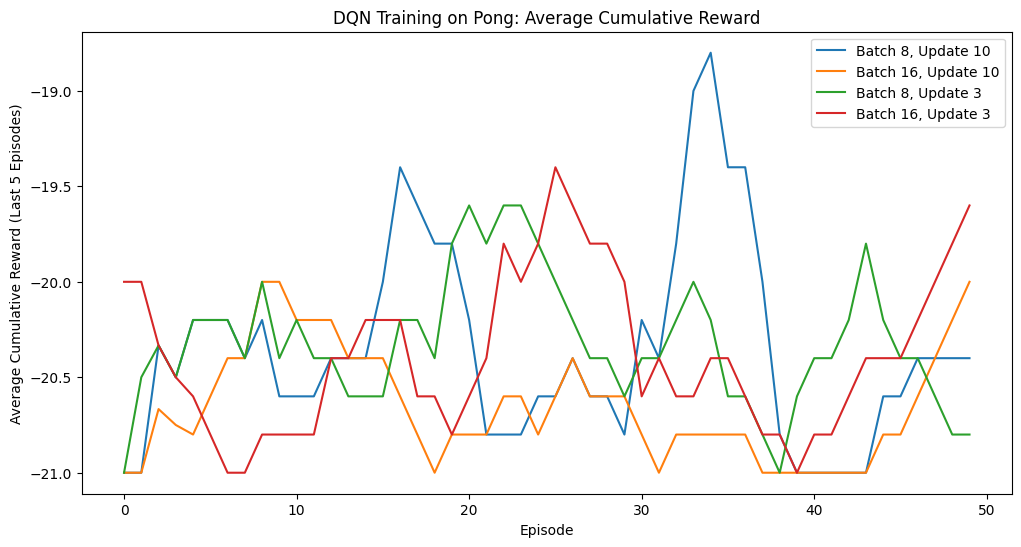

In [21]:
# -------------------------------
# Setup and Execution
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create the Pong environment
try:
    # For newer gym versions (>0.26.0)
    env = gym.make("PongDeterministic-v4", render_mode=None)
except:
    # Fallback for older gym versions
    env = gym.make("PongDeterministic-v4")

num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

# Processed image dimensions
image_dims = (84, 80)  # (height, width)
# Input shape for the network: 4 stacked frames
input_shape = (4, image_dims[0], image_dims[1])

# Define experiment configurations
experiments = [
    {"batch_size": 8, "target_update": 10, "label": "Batch 8, Update 10"},
    {"batch_size": 16, "target_update": 10, "label": "Batch 16, Update 10"},
    {"batch_size": 8, "target_update": 3, "label": "Batch 8, Update 3"},
    {"batch_size": 16, "target_update": 3, "label": "Batch 16, Update 3"}
]

num_episodes = 50  # Adjust as needed for your experiments
results = {}

for exp in experiments:
    print("\nRunning experiment:", exp["label"])
    agent = DQNAgent(input_shape, num_actions, device, batch_size=exp["batch_size"])
    scores, avg_rewards = train(agent, env, num_episodes, exp["target_update"], image_dims)
    results[exp["label"]] = {"scores": scores, "avg_rewards": avg_rewards}

env.close()

# Plotting the Results
plt.figure(figsize=(12, 6))
for label, data in results.items():
    plt.plot(data["avg_rewards"], label=label)
plt.xlabel("Episode")
plt.ylabel("Average Cumulative Reward (Last 5 Episodes)")
plt.title("DQN Training on Pong: Average Cumulative Reward")
plt.legend()
plt.show()

## Report and Analysis

This report summarizes the results of training a **Deep Q-Network (DQN)** agent on the **PongDeterministic-v4** environment from OpenAI Gym. The goal was to train an agent to play Pong efficiently by learning from raw pixel inputs. The training was conducted with different hyperparameters, including **batch sizes** (8 and 16) and **target network update frequencies** (3 and 10 episodes). The performance of the agent was evaluated based on the **score per episode** and the **average cumulative reward of the last 5 episodes**.

---

#### **Training Setup**
- **Environment**: PongDeterministic-v4 (6 actions, observation space: 210x160x3 RGB images).
- **Preprocessing**:
  - Frames were cropped, downsampled, converted to grayscale, and normalized.
  - Four consecutive frames were stacked to form the state input to the network.
- **DQN Architecture**:
  - **Convolutional Layers**:
    - 32 filters (8x8 kernel, stride 4), ReLU activation.
    - 64 filters (4x4 kernel, stride 2), ReLU activation.
    - 64 filters (3x3 kernel, stride 1), ReLU activation.
  - **Fully Connected Layers**:
    - 512 units, ReLU activation.
    - Output layer with 6 units (one for each action).
- **Hyperparameters**:
  - Discount factor (γ): 0.95.
  - Learning rate: 1e-4.
  - Exploration:
    - Initial epsilon (ϵinit): 1.0.
    - Epsilon decay rate (δ): 0.995.
    - Minimum epsilon (ϵmin): 0.05.
  - Replay buffer capacity: 10,000.
  - Batch sizes: 8 and 16.
  - Target network update frequencies: 3 and 10 episodes.

---

#### **Training Results**

| **Configuration** | **Final Avg Reward (Last 5 Episodes)** | **Best Avg Reward** | **Performance Trend** |
|-------------------|----------------------------------------|---------------------|------------------------|
| **Batch Size: 8, Target Update: 10** | -20.40 | -18.80 | Improved initially but declined later. Frequent updates provided stability but potentially slowed adaptation. |
| **Batch Size: 16, Target Update: 10** | -20.00 | -20.00 | Larger batch size provided more stable gradients, but performance remained flat. Less frequent target updates contributed to slower learning. |
| **Batch Size: 8, Target Update: 3** | -20.80 | -19.60 | Showed some improvement but struggled with stability due to more frequent target updates. Smaller batch sizes allowed faster learning but introduced more variance. |
| **Batch Size: 16, Target Update: 3** | -19.60 | -19.40 | Best overall performance. The combination of larger batch size and more frequent target updates provided a balance between stability and adaptation. |

---

#### **Key Observations**
1. **Batch Size**:
   - **Smaller Batch Size (8)**: Faster learning but higher variance in performance.
   - **Larger Batch Size (16)**: More stable gradients but slower updates.

2. **Target Network Update Frequency**:
   - **Less Frequent Updates (10 Episodes)**: Provided stability but slowed adaptation.
   - **More Frequent Updates (3 Episodes)**: Improved adaptation but introduced instability.

3. **Exploration vs. Exploitation**:
   - Epsilon decayed from 1.0 to 0.05 over episodes, balancing exploration and exploitation.
   - Early episodes were dominated by exploration, while later episodes focused on exploitation.

4. **Performance Trends**:
   - The agent struggled to achieve positive rewards, indicating that further tuning or longer training may be required.
   - The best performance was achieved with a **batch size of 16** and a **target network update frequency of 3 episodes**.

---

#### **Recommendations**
Based on the results, the **best combination of hyperparameters** is:
- **Batch Size**: 16.
- **Target Network Update Frequency**: 3 episodes.

From Research, the following recommendations can be made to improve the agent's performance:
1. **Speed Up Training**
    - **Increase Batch Size & Steps**: Train every 4 environment steps with batch sizes of 32–64 for a 47% speedup.
    - **Parallelize Training & Environment**: Use torch.multiprocessing to run both simultaneously, boosting speed by 74%.
    - **Async CUDA Transfers**: Enable async=True for faster CPU-GPU data transfer (3.5% speedup).

2. **Optimize Environment Preprocessing**
    - **Use Fast Atari Wrappers**: Switch to OpenCV-based wrappers (18% faster).
    - **Essential Wrappers**: Use EpisodicLifeEnv, FrameStack, and ClippedRewardWrapper for stability and efficiency.

3. **Tune Hyperparameters**
    - **Refine Epsilon Decay**: Adjust exploration rates for better learning (e.g., 1.0 → 0.02 over 100k frames).
    - **Frequent Target Updates**: Sync every 1k frames for stability.

4. **Use Advanced DQN Techniques**
    - **Double DQN, PER, Dueling DQN**: Improve efficiency and stability.
    - **Train Longer**: Process 484 frames/sec to solve Pong in 30 min.

5. **Maximize GPU Utilization**
    - Optimize batch sizes, parallel tasks, and scale to tougher Atari games.
---

#### **Conclusion**
The DQN agent demonstrated the ability to learn from raw pixel inputs in the Pong environment. However, the agent's performance was limited, and further improvements could be achieved by:
- **Increasing the number of training episodes**.
- **Tuning hyperparameters** (e.g., learning rate, discount factor).
- **Using advanced techniques** such as Double DQN, Prioritized Experience Replay, or Dueling DQN.

The results highlight the importance of hyperparameter tuning in reinforcement learning and provide a foundation for future experiments.